In [25]:
import numpy as np
import json
from typing import List
import math
import os, os.path
from collections import defaultdict
import matplotlib.pyplot as plt

Got a dataset from Slay The Spire official discord where Baalor posted data about around 700 of his runs in 2022.

### Can we deterministically say what's the state of the deck at any floor?


In [4]:
data = json.load(open("C:/Users/lgerretsen/perso/perso/sts/2019-05-31-00-53#1028.json", "r"))


In [14]:
sample = data[0]
assert set(sample.keys()) == {'event'}
sample = sample["event"]
sample.keys()

dict_keys(['gold_per_floor', 'floor_reached', 'playtime', 'items_purged', 'score', 'play_id', 'local_time', 'is_ascension_mode', 'campfire_choices', 'neow_cost', 'seed_source_timestamp', 'circlet_count', 'master_deck', 'relics', 'potions_floor_usage', 'damage_taken', 'seed_played', 'potions_obtained', 'is_trial', 'path_per_floor', 'character_chosen', 'items_purchased', 'campfire_rested', 'item_purchase_floors', 'current_hp_per_floor', 'gold', 'neow_bonus', 'is_prod', 'is_daily', 'chose_seed', 'campfire_upgraded', 'win_rate', 'timestamp', 'path_taken', 'build_version', 'purchased_purges', 'victory', 'max_hp_per_floor', 'card_choices', 'player_experience', 'relics_obtained', 'event_choices', 'is_beta', 'boss_relics', 'items_purged_floors', 'is_endless', 'potions_floor_spawned', 'killed_by', 'ascension_level'])

In [15]:
sample["neow_bonus"]

'REMOVE_TWO'

In [16]:
sample["items_purged_floors"]


[7]

In [24]:
idx = 0
while 1:
    sample = data[idx]["event"]
    if sample["victory"]:
        break
    idx += 1
json.dump(sample, open("./example_vanilla.run", "w"), indent=4)

,Unnamed: 0,epoch,training_loss,training_top_inf_acc,training_top_true_acc,val_loss,val_top_inf_acc,val_top_true_acc
0,0,0,2.148810,0.433225,0.726562,1.690723,0.227604,0.652344
1,1,1,1.780216,0.250455,0.705078,1.824815,0.216113,0.644531
2,2,2,1.704409,0.209375,0.642578,NaN,NaN,NaN
3,3,3,1.818883,0.217122,0.664062,NaN,NaN,NaN
4,4,4,1.795968,0.209310,0.640625,NaN,NaN,NaN


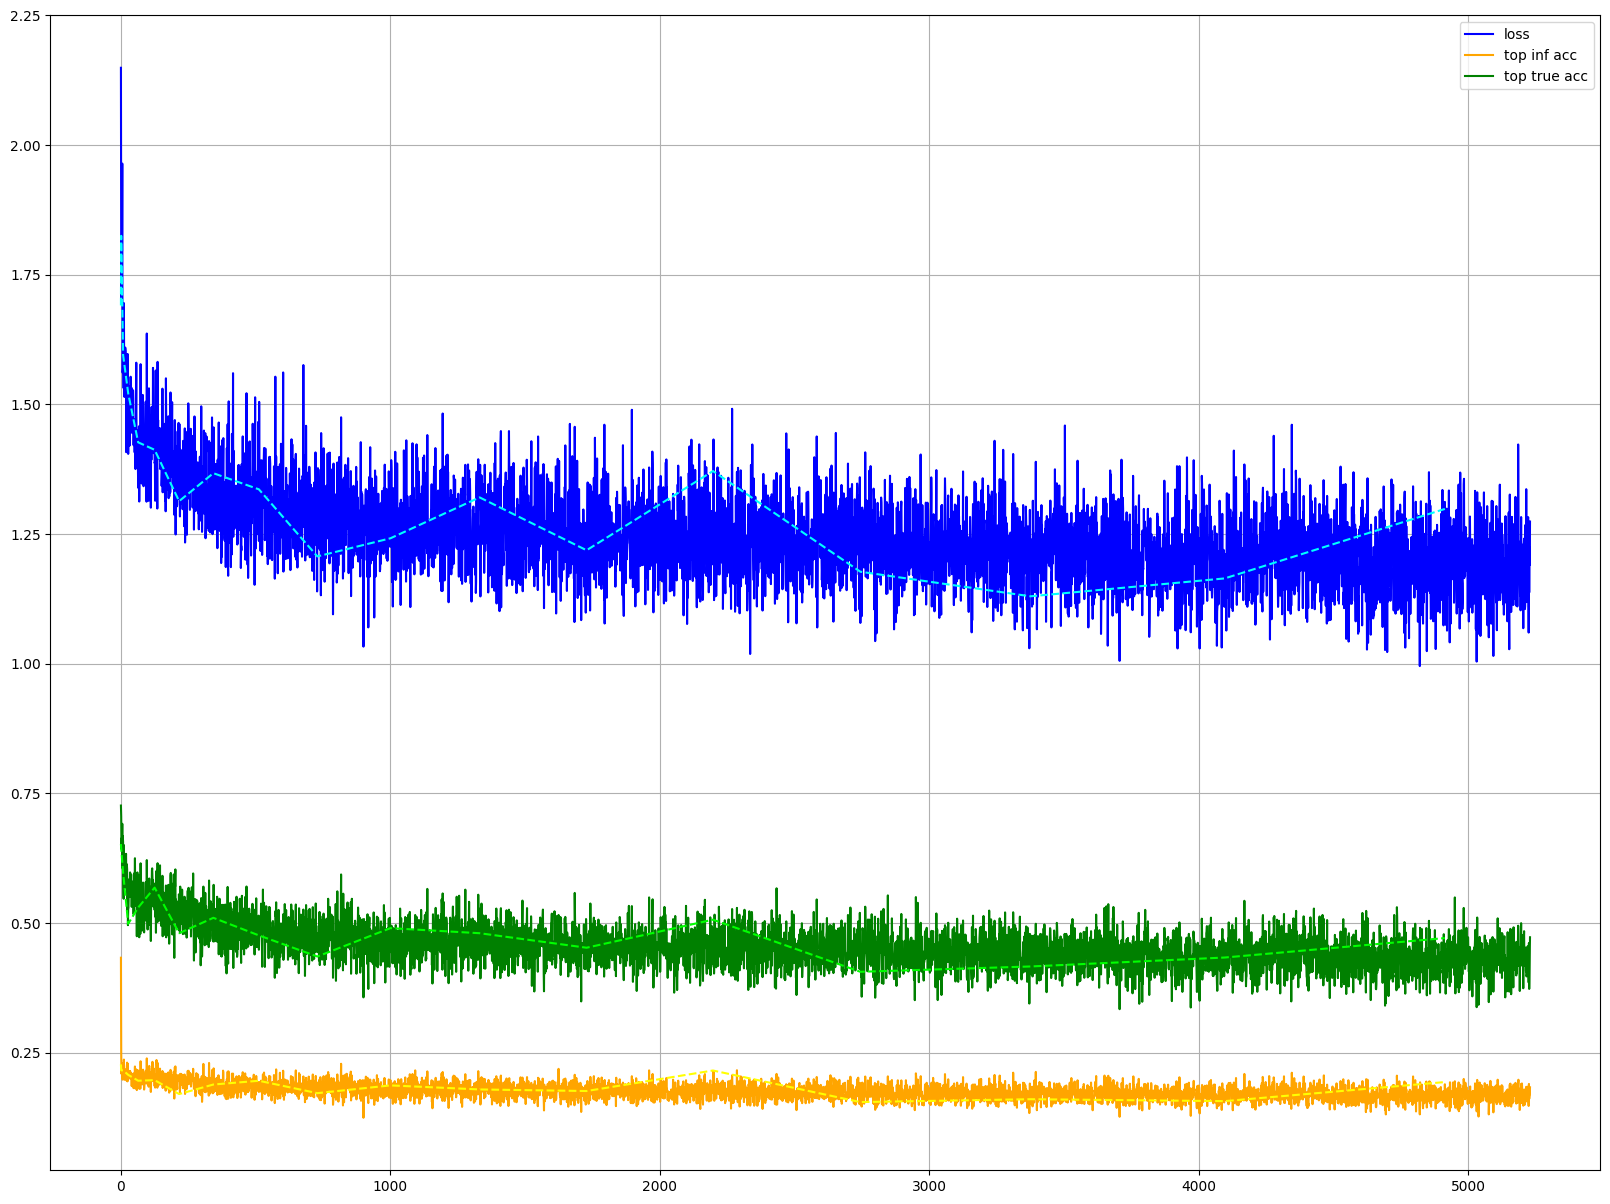

In [55]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import time

training_dirname = ""
training_dirname = "2023-02-01-22-20-23_blocks4-256_split0.8"
# training_dirname = "2023-01-15-18-12-13_blocks4-256_split0.8"
# training_dirname = "2023-01-15-14-13-51_blocks4-256_split0.8"
# training_dirname = "2023-01-14-15-47-15_blocks4-256_split0.8"
# training_dirname = "2023-01-07-20-10-29_blocks4-256_split0.8"
# training_dirname = "2023-01-06-20-25-13_21400_blocks4-256_split0.8"
# training_dirname = "2023-01-01-14-41-22_november_blocks4-256_split0.8"
# training_dirname = "2023-01-01-14-13-45_november_blocks4-256_split0.2"
# training_dirname = "2023-01-01-14-10-46_november_blocks4-128_split0.001"
# training_dirname = "2022-12-23-21-39-39_november_blocks8"
# training_dirname = "2022-12-21-22-51-42_november"

plt.figure(figsize=(20,15))

while 1:
    df = pd.read_csv(f"trainings/{training_dirname}/metrics.csv")

    plt.cla()
    plt.grid()

    epochs = df.epoch
    plt.plot(epochs, list(df.training_loss), color="blue", label="loss")
    plt.plot(epochs, list(df.training_top_inf_acc), color="orange", label="top inf acc")
    plt.plot(epochs, list(df.training_top_true_acc), color="green", label="top true acc")

    def plot_holed_values(epochs, values, color, linestyle):
        xs = [x for x,val in zip(epochs, values) if not math.isnan(val)]
        ys = [val for x,val in zip(epochs, values) if not math.isnan(val)]
        plt.plot(xs, ys, color=color, linestyle=linestyle)
    plot_holed_values(epochs, list(df.val_loss), color="cyan", linestyle='dashed')
    plot_holed_values(epochs, list(df.val_top_inf_acc), color="yellow", linestyle='dashed')
    plot_holed_values(epochs, list(df.val_top_true_acc), color="lime", linestyle='dashed')
    plt.legend()
    # plt.pause(1.)

    break

df.head()



In [2]:
import re
import pandas as pd
import numpy as np
from glob import glob
import os, os.path
import json
import torch

from sts_ml.train import Model, pad_samples, TRAINING_DIR, PARAMS_FILENAME, TOKENS_FILENAME, load_datasets
from sts_ml.infer import count_parameters, TRAINING_DIR, PARAMS_FILENAME, pad_samples

# training_dirname = ""
# training_dirname = "2023-01-15-18-12-13_blocks4-256_split0.8"
# training_dirname = "2023-01-14-15-47-15_blocks4-256_split0.8"
# training_dirname = "2023-01-14-15-31-48_blocks1-256_split0.8"
# training_dirname = "2023-01-14-15-23-42_blocks1-256_split0.8"
# training_dirname = "2023-01-14-14-58-28_blocks1-256_split0.8"
# training_dirname = "2023-01-14-12-26-24_blocks4-256_split0.8"
# training_dirname = "2023-01-06-23-41-35_21400_blocks4-256_split0.8"
# training_dirname = "2023-01-06-20-25-13_21400_blocks4-256_split0.8"

training_dir = os.path.join(".", TRAINING_DIR, training_dirname)
params = json.load(open(os.path.join(training_dir, PARAMS_FILENAME), "r"))

data_tokens, train_dataset, val_dataset = load_datasets(params)



Train (343523) / validation (85881) ratio = 0.8


In [56]:
model = Model(params, tokens=data_tokens)

ckpt_filename = os.path.join(training_dir, "4096.ckpt")

state_dict = torch.load(ckpt_filename)
assert count_parameters(list(model.parameters())) == count_parameters(list(state_dict.values())), (count_parameters(list(model.parameters())), count_parameters(list(state_dict.values())))
model.load_state_dict(state_dict)
model.dataset = val_dataset
model.eval()


Model(
  (embedding): Embedding(557, 256)
  (blocks): ModuleList(
    (0): MHALayer(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff1): Linear(in_features=256, out_features=512, bias=True)
      (relu): ReLU()
      (ff2): Linear(in_features=512, out_features=256, bias=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): MHALayer(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff1): Linear(in_features=256, out_features=512, bias=True)
      (relu): ReLU()
      (ff2): Linear(in_features=512, out_features=256, bias=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (2): MHALayer(
      (att): 

In [57]:
for p, key, q in zip(list(model.parameters()), list(state_dict.keys()), list(state_dict.values())):
    if p.shape != q.shape:
        assert False, (key, p.shape,q.shape)

In [58]:
sample = val_dataset.sample_unpreprocessed()
sample

{'relics': ['potionbelt',
  'deadbranch',
  'theabacus',
  'artofwar',
  'torii',
  'ancientteaset',
  'toxicegg2',
  'meatonthebone',
  "lee'swaffle",
  'mango',
  'pantograph',
  'dollysmirror',
  'fusionhammer'],
 'deck': ['defend_r',
  'defend_r',
  'defend_r',
  'strike_r',
  'strike_r',
  'bash',
  'ascendersbane',
  'ghostlyarmor',
  'truegrit',
  'armaments+1',
  'thunderclap',
  'discovery',
  'shrugitoff',
  'juggernaut+1',
  'truegrit',
  'shrugitoff',
  'metallicize',
  'dramaticentrance',
  'impervious+1',
  'masterofstrategy+1',
  'juggernaut'],
 'cards_picked': ['bodyslam'],
 'cards_skipped': ['headbutt', 'bloodletting+1']}

In [59]:
sample = val_dataset.sample_unpreprocessed()
model.predict_one(sample)


             cards expert_scores predicted_scores
0       defend_r+1          deck             deck
1         defend_r          deck             deck
2         defend_r          deck             deck
3         strike_r          deck             deck
4         strike_r          deck             deck
5         strike_r          deck             deck
6           bash+1          deck             deck
7    ascendersbane          deck             deck
8         disarm+1          deck             deck
9     pommelstrike          deck             deck
10     demonform+1          deck             deck
11       shockwave          deck             deck
12        headbutt          deck             deck
13            feed          deck             deck
14  spotweakness+1          deck             deck
15  necronomicurse          deck             deck
16          disarm          deck             deck
17  pommelstrike+1          deck             deck
18          reaper          deck             deck


In [60]:
sample = {
    'relics': [],
    'deck': [
        'defend_r',
        'defend_r',
        'defend_r',
        'defend_r+1',
        'strike_r',
        'strike_r',
        'bash',
        'ascendersbane',
        'havoc+1',
        'recklesscharge+1',
        'rampage',
        'headbutt',
        'shrugitoff',
        'feelnopain',
        'impervious',
        'brutality+1',
        'feed',
        'shrugitoff+1',
        'truegrit+1',
    ],
    'cards_picked': [
    ],
    'cards_skipped': [
        # 'ironwave',
        # 'combust',
        # 'bodyslam',
        # 'perfectedstrike',
        # 'twinstrike',
        # 'sentinel',
        # 'darkembrace',
        # 'cleave',
        # 'swordboomerang',
        # 'carnage',
        # 'searingblow',
        # 'flex',
        # 'warcry',
        # 'powerthrough',
        # 'rupture',
        # 'rampage',
        # 'thunderclap',
        # 'doubletap',
        # 'limitbreak+1',
        # 'berserk',
        # 'headbutt',
        # 'inflame',
        'feed',
        'armaments+1',
        'pommelstrike',
    ],
}
model.predict_one(sample)


               cards expert_scores predicted_scores
0           defend_r          deck             deck
1           defend_r          deck             deck
2           defend_r          deck             deck
3         defend_r+1          deck             deck
4           strike_r          deck             deck
5           strike_r          deck             deck
6               bash          deck             deck
7      ascendersbane          deck             deck
8            havoc+1          deck             deck
9   recklesscharge+1          deck             deck
10           rampage          deck             deck
11          headbutt          deck             deck
12        shrugitoff          deck             deck
13        feelnopain          deck             deck
14        impervious          deck             deck
15       brutality+1          deck             deck
16              feed          deck             deck
17      shrugitoff+1          deck             deck
18        tr

In [44]:
import copy
import pandas as pd
from sts_ml.train import unpad
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)


def attn_weights_to_df(attn_weights, sample):
    sample = unpad(sample)
    deck_n = len(sample["deck"])
    cards_picked_n = len(sample["cards_picked"])
    cards_skipped_n = len(sample["cards_skipped"])

    assert len(attn_weights.shape) == 2
    tokens = sample["deck"] + sample["cards_picked"] + sample["cards_skipped"]
    attn_weights = attn_weights[-len(tokens):,-len(tokens):]
    df = pd.DataFrame(attn_weights)
    df = df.rename(columns=lambda idx: f"{idx} {tokens[idx]}", index=lambda idx: f"{idx} {tokens[idx]}")
    
    styler = df
    styler = styler.style.background_gradient(cmap=cm)
    styler = styler.format(precision=3)
    
    return styler

for block in model.blocks:
    attn_weights = block.attn_weights.detach().cpu().numpy()
    df = attn_weights_to_df(attn_weights[0], sample)

df

,0 defend_r+1,1 defend_r+1,2 defend_r+1,3 defend_r+1,4 strike_r+1,5 strike_r+1,6 strike_r+1,7 strike_r+1,8 bash+1,9 ascendersbane,10 disarm+1,11 fiendfire+1,12 armaments,13 havoc+1,14 exhume,15 shrugitoff,16 truegrit,17 offering,18 truegrit,19 intimidate,20 corruption+1,21 flamebarrier,22 sentinel,23 seeingred,24 warcry,25 twinstrike,26 headbutt+1
0 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
1 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
2 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
3 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
4 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
5 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
6 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
7 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
8 bash+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.011,0.012,0.016,0.028,0.030,0.017,0.019,0.017,0.018,0.022,0.018,0.012,0.013,0.020,0.015,0.015,0.034,0.029,0.023
9 ascendersbane,0.017,0.017,0.017,0.017,0.018,0.018,0.018,0.018,0.021,0.012,0.036,0.024,0.027,0.033,0.017,0.014,0.022,0.015,0.022,0.028,0.017,0.017,0.031,0.017,0.054,0.045,0.079


In [47]:
attn_weights.sum(axis=2)

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99999994,
        0.99999994, 0.99999994, 0.99999994, 1.  

In [48]:
t = np.ones((2,2))
t[0,1] = 0
df = pd.DataFrame(t)
df["a"] = ["b", "c"]

df = df.style.background_gradient(cmap=cm)
df


,0,1,a
0,1.000000,0.000000,b
1,1.000000,1.000000,c


In [39]:
import copy
sample = copy.deepcopy(val_dataset[5])
sample['deck'] = sample['deck'][-24:]

In [77]:
from sts_ml.train import pad_sample
sample = {
    'deck': [
        'strike_r',
        'strike_r',
        'strike_r',
        'strike_r',
        'strike_r',
        'defend_r',
        'defend_r',
        'defend_r',
        'defend_r',
        'bash+1',
        'whirlwind+1',
        'darkshackles+1',
        'hemokinesis+1',
        'reaper',
        'anger',
        'fiendfire',
        'battletrance',
        'infernalblade',
        # 'apparition',
        # 'apparition',
        # 'apparition',
        'doubletap',
        'impervious',
        'shrugitoff',
    ],
    'cards_picked': [],
    'cards_skipped': [
        # 'clothesline',
        # 'flex',
        # 'perfectedstrike',
        # 'swordboomerang',
        # 'shrugitoff',
        # 'truegrit',
        # 'wildstrike',
        # 'twinstrike',
        # 'warcry',
        # 'ironwave',
        # 'headbutt',
        # 'clash',

        # 'whirlwind',
        # 'searingblow',
        # 'shockwave',
        # 'dualwield',
        # 'rampage',
        # 'recklesscharge',
        # 'metallicize',
        # 'infernalblade',
        # 'battletrance',
        # 'uppercut',
        # 'evolve',

        'reaper',
        # 'fiendfire',
        # 'demonform',
        # 'corruption',
        # 'doubletap',
        'impervious',
        'immolate',
    ],

}
sample = pad_sample(sample, len(val_dataset[0]))
model.predict(sample)


             cards expert_scores predicted_scores
0         strike_r          deck             deck
1         strike_r          deck             deck
2         strike_r          deck             deck
3         strike_r          deck             deck
4         strike_r          deck             deck
5         defend_r          deck             deck
6         defend_r          deck             deck
7         defend_r          deck             deck
8         defend_r          deck             deck
9           bash+1          deck             deck
10     whirlwind+1          deck             deck
11  darkshackles+1          deck             deck
12   hemokinesis+1          deck             deck
13          reaper          deck             deck
14           anger          deck             deck
15       fiendfire          deck             deck
16    battletrance          deck             deck
17   infernalblade          deck             deck
18       doubletap          deck             deck


In [6]:
from sts_ml.deck_history import card_to_n_upgrades
from sts_ml.train import token_to_index

samples = val_dataset[:1]

padded_samples = pad_samples(samples)
batched_idxes = []
deck_sizes = []
n_upgrades = []
for sample in padded_samples:
    tokens = sample["deck"] + sample["cards_picked"] + sample["cards_skipped"]
    idxes = [token_to_index(token) for token in tokens]
    batched_idxes.append(idxes)
    deck_sizes.append(len(sample["deck"]))
    n_upgrades.append([card_to_n_upgrades(token) for token in tokens])
batched_idxes = np.array(batched_idxes)
batched_idxes = torch.from_numpy(batched_idxes).to(model.device)
deck_sizes = np.array(deck_sizes)
n_upgrades = np.array(n_upgrades)
n_upgrades = torch.from_numpy(n_upgrades).to(model.device)

In [10]:
print(tokens)

['PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'defend_r+1', 'defend_r+1', 'defend_r+1', 'defend_r+1', 'strike_r+1', 'strik

In [15]:
token_to_index(ALL_TOKENS[2])

2

In [12]:
batched_idxes

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0, 351, 351, 351, 351, 239, 239, 239, 239, 124, 348, 144, 105, 312,
          87, 157, 218, 253, 221, 253,  35, 112]], device='cuda:0',
       dtype=torch.int32)

In [17]:
ALL_TOKENS[1]

'eviscerate'

In [2]:
from sts_ml.train import ALL_TOKENS
ALL_TOKENS.index('defend_r')

145

In [2]:
import json

from sts_ml.train import Model
from sts_ml.params import params

model = Model(params)
data = json.load(open(params["train"]["dataset"], "r"))


In [36]:
import numpy as np
import random

import torch
from torch.utils.data import IterableDataset, DataLoader
from torch.utils.data._utils import collate

from sts_ml.train import PAD_TOKEN
from sts_ml.deck_history import card_to_name, card_to_n_upgrades

class DeckAndRewardDataset(IterableDataset):
    PAD_INDEX = 0

    def __init__(self, samples: list, tokens):
        self.samples = samples
        self.tokens = tokens
        assert tokens.index(PAD_TOKEN) == DeckAndRewardDataset.PAD_INDEX

    def token_to_index(self, token : str):
        name = card_to_name(token)
        assert name in self.tokens, name
        index = self.tokens.index(name)
        return index
    
    def generator(self):
        while 1:
            sample = random.choice(self.samples)
            ret = self.preprocess(sample)
            yield ret
    
    def preprocess(self, sample: dict):
        tokens = sample["deck"] + sample["cards_picked"] + sample["cards_skipped"]
        idxes = np.array([self.token_to_index(token) for token in tokens], dtype=int)
        deck_n = len(sample["deck"])
        cards_picked_n = len(sample["cards_picked"])
        cards_skipped_n = len(sample["cards_skipped"])
        n_upgrades = np.array([card_to_n_upgrades(token) for token in tokens], dtype=int)

        ret = {
            "token_idxes": idxes,
            "deck_n": deck_n,
            "cards_picked_n": cards_picked_n,
            "cards_skipped_n": cards_skipped_n,
            "n_upgrades": n_upgrades,
        }
        return ret


    def __iter__(self):
        return self.generator()

    @staticmethod
    def collate_fn(samples):
        max_seq_len = -1
        for sample in samples:
            seq_len = sample["deck_n"] + sample["cards_picked_n"] + sample["cards_skipped_n"]
            max_seq_len = max(max_seq_len, seq_len)
        assert max_seq_len > -1, max_seq_len

        for sample in samples:
            seq_len = sample["deck_n"] + sample["cards_picked_n"] + sample["cards_skipped_n"]
            n_pad_left = max_seq_len - seq_len
            padding = DeckAndRewardDataset.PAD_INDEX * np.ones(n_pad_left, dtype=int)
            sample["token_idxes"] = np.hstack([padding, sample["token_idxes"]])
            sample["n_upgrades"] = np.hstack([padding, sample["n_upgrades"]])
            sample["n_pad_lefts"] = n_pad_left
        
        ret = {}
        for key in ["token_idxes", "n_upgrades"]:
            ret[key] = collate.default_collate([sample[key] for sample in samples])
        
        for key in ["deck_n", "cards_picked_n", "cards_skipped_n", "n_pad_lefts"]:
            ret[key] = [sample[key] for sample in samples]

        return ret

dataset = DeckAndRewardDataset(
    samples=data["dataset"],
    tokens=model.tokens,
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=2,
    collate_fn=DeckAndRewardDataset.collate_fn,
    pin_memory=True,
    pin_memory_device=model.device,
)

batch = next(iter(dataloader))
batch


{'token_idxes': tensor([[145, 145, 145, 145,  32,  32,  32,  32,  15, 355, 299, 295,  17, 150,
          132, 303,   5, 125, 303, 281, 306, 134, 132, 296,   3],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 145, 145, 145,
          145,  32,  32,  32,  32,  15, 355,  23, 129, 124, 300]],
        dtype=torch.int32),
 'n_upgrades': tensor([[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
          0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0]], dtype=torch.int32),
 'deck_n': [22, 11],
 'cards_picked_n': [0, 1],
 'cards_skipped_n': [3, 2]}

In [37]:
model.device

'cuda'

In [38]:
batch["token_idxes"].device

device(type='cpu')

In [63]:
import numpy as np
import torch

N = 4
top_picked_target = np.array([1,2])
picked_n = len(top_picked_target)
logits = torch.tensor(np.random.rand(N))
predict_picked_n = torch.sum(logits > 0.5).item()
print(logits)
sorted_picks_pred = torch.argsort(- logits)
top_picked_preds = sorted_picks_pred[:min(picked_n, predict_picked_n)]
top_picked_target = torch.tensor(top_picked_target)
diff = top_picked_preds[None, :] == top_picked_target[:, None]
score = torch.sum(diff.float()) / picked_n
score

tensor([0.4175, 0.7115, 0.9191, 0.5230], dtype=torch.float64)


tensor(1.)